<a href="https://colab.research.google.com/github/psahai10/AIFellowship/blob/main/CLIPwFood101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-shot Food Classification
# Project Overview:
The objective of this track is to do zero shot classification for food types on previously unseen data. This is to be done by using CLIP(https://openai.com/blog/clip/). Work on food classification has been done by previous cohorts(https://fellowshipai.wordpress.com/raw-food-identification/), but we have found the following limitations with the approaches used:

1. They require a huge amount of resources(both in time as well as manpower) to annotate the data.
2. These algorithms are not able to generalize well to images that is not setup in the same setting as the data that model was trained upon.
3. They do not work on food types that are not present in the provided labels, hence requiring more resources with the increase with changes and updates to the application.

CLIP provides a way to overcome the said issues by using data that is freely available on the internet, without having to need a any sort of manual annotation. As we are free to use a large amount of data, the algorithm will be able to generalize better than a standard ResNet model to any kind of changes in how the image is presented and the final set of labels for prediction can be incremented as required without any extra work.
## Application:

The developed algorithm will be used to detect in-oven food types on the go and process them accordingly. With a robust zero-shot classification mechanism, the amount of manual work required to update the models periodically and label them can be mitigated by a huge amount. It might also help detect and classify multiple food types in case they are present in the image, depending on the type of decoder that will be used.

## Tasks:

The tasks in this track will be divided into two categories, the first will pertain to application and understanding of how CLIP works and in the second task, we will try to delve deeper into the research used and work on creating a general purpose algorithm.

1. Apply and test CLIP for existing in-oven food classification task
2. Work and build on the methodologies used in CLIP and other similar papers to create a more efficient zero shot classification algorithm that does not require huge amount of resources (data and compute) and is able to produce robust results on unseen data.

# 1. Import CLIP and other dependencies

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

import matplotlib.pyplot as plt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 71kB 3.2MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=95060cb590443eaca2e858dc67358fe61379539c585a876bad0416abe9929972
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy
Torch version: 1.7.1+cu101


In [ ]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.
/content/CLIP


In [ ]:
import torch
import clip
from PIL import Image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, transform = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 152MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-03-01 16:37:34--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.1s    

2021-03-01 16:37:34 (9.91 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



# 2. Text encoder used in open.ai

In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

# 3. Download and extract food101 dataset.

In [ ]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
import os
os.listdir('food-101/images')

['peking_duck',
 'scallops',
 'mussels',
 'grilled_salmon',
 'beignets',
 'beef_tartare',
 'pad_thai',
 'fried_calamari',
 'risotto',
 'pho',
 'french_toast',
 'red_velvet_cake',
 'chicken_quesadilla',
 'breakfast_burrito',
 'club_sandwich',
 'filet_mignon',
 'takoyaki',
 'fish_and_chips',
 'creme_brulee',
 'edamame',
 'poutine',
 'miso_soup',
 'apple_pie',
 'eggs_benedict',
 'deviled_eggs',
 'macarons',
 'greek_salad',
 'beet_salad',
 'foie_gras',
 'caesar_salad',
 'hot_dog',
 'bruschetta',
 'croque_madame',
 'onion_rings',
 'churros',
 'baklava',
 'frozen_yogurt',
 'ramen',
 'steak',
 'guacamole',
 'cheese_plate',
 'lobster_roll_sandwich',
 'fried_rice',
 'nachos',
 'dumplings',
 'oysters',
 'paella',
 'chicken_wings',
 'spaghetti_carbonara',
 'beef_carpaccio',
 'french_fries',
 'cannoli',
 'chocolate_mousse',
 'hummus',
 'chocolate_cake',
 'huevos_rancheros',
 'sashimi',
 'pancakes',
 'sushi',
 'grilled_cheese_sandwich',
 'baby_back_ribs',
 'omelette',
 'gyoza',
 'macaroni_and_chees

In [ ]:
os.listdir('food-101/meta')

['test.txt',
 'labels.txt',
 'train.txt',
 'test.json',
 'train.json',
 'classes.txt']

In [ ]:
# Helper method to split dataset into train and test folders
import numpy as np
from collections import defaultdict
import collections
import os
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
categories = os.listdir('food-101/images')

# 4. Select images from Food-101 for predictions

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions

# descriptions = {
#     "steak": "This is a photo of steak, a type of beef",
#     "ravioli": "this is photo of ravioli, a type of pasta",
#     "pork_chop": "this is a photo of pork chops, a type of pork",
#     "apple_pie": "this is a photo of an apple pie, a type of baked dessert",
#     "beet_salad": "this is a photo of beet salad, a type of vegetable salad",
#     "tuna_tartare": "this is a photo of tuna tartare, a type of raw seafood",
#     "ramen": "this is a photo of ramen, a type of japannese noodle dish", 
#     "lasagna": "this is a photo of a lasagna, a type of Italian dish",
#     # "strawberry_shortcake": "This is a photo of strawberry shortcake, a type of dessert",
#     # "cheesecake": "this is photo of cheesecake, a type of dessert",
#     # "garlic_bread": "this is a photo of garlic bread, a type of bread",
#     # "ceviche": "this is a photo of ceviche, a type of raw seafood dish",
#     # "grilled_cheese_sandwich": "this is a photo of a grilled cheese sandwich",
#     # "scallops": "this is a photo of scallops, a type of seafood",
#     # "risotto": "this is a photo of risotto, a type of italian dish", 
#     # "onion_rings": "this is a photo of onion rings, a type of fast food",
#     #  "gnocchi": "this is a photo of gnocchi, a type of italian dish", 
#     # "tiramisu": "this is a photo of a tiramisu, a type of dessert"
# }

descriptions = {
    "beignets": "This is a photo of a beignets",
    "bibimbap": "This is a photo of a bibimbap",
    "grilled_salmon": "This is a photo of a grilled salmon",
    "gyoza": "This is a photo of a gyoza",
    "panna_cotta": "This is a photo of a panna_cotta",
    "takoyaki": "This is a photo of a takoyaki",
    "peking_duck": "This is a photo of a peking duck",
    "poutine": "This is a photo of a poutine"

}

# Long prompts (still needs a little cleaning)


In [ ]:
dictionary = {'apple_pie' : 'This is a photo of an apple_pie, a type of flour dessert with a baked crust ',
              'baby_back_ribs': 'This is a photo of baby back ribs, a type of a type of meat from beef',
              'baklava': 'This is a photo of baklava, a type of greek dessert',
              'beef_carpaccio': 'This is a photo of beef carpaccio, a type of traditional Italian appetizer consisting of raw beef sliced paper-thin',
              'beef_tartare': 'This is a photo of beef tartare, a meat dish made from raw ground minced beef',
              'beet_salad': 'This is a photo of beet salad, a type of red vegetable from beetroot',
              'beignets': 'This is a photo of a beignets, a type of fritter, or deep-fried pastry, typically made from pâte à choux',
              'bibimbap': 'This is a photo of a bibimbap, a type of Korean rice dish served as a bowl of warm white rice topped with namul or kimchi and gochujang, soy sauce, or doenjang',
              'bread_pudding': 'This is a photo of a bread pudding, a type of bread based dessert made with stale bread and dried fruit',
              'breakfast_burrito': 'This is a photo of a breakfast burrito , a type of breakfast wrap composed of eggs, toppings, and sauce in a flour tortilla',
              'bruschetta': 'This is a photo of a bruschetta, a type of an antipasto from Italy consisting of grilled bread rubbed with garlic, tomato and topped with olive oil ',
              'caesar_salad': 'This is a photo of a ceasar salad , a type of a green salad with romaine lettuce and croutons',
              'cannoli': 'This is a photo of a cannoli, Italian pastries consisting of tube-shaped shells of fried pastry dough, filled with a sweet, creamy filling usually containing ricotta—a staple of Sicilian cuisine.  ',
              'caprese_salad': 'This is a photo of a caprese_salad, simple Italian salad made from  mozzarella, tomatoes, and sweet basil',
              'carrot_cake': 'This is a photo of a carrot cake, a type of cake that contains carrots mixed into the batter and have a white cream cheese frosting',
              'ceviche': 'This is a photo of a ceviche, a type of  is a South American seafood dish that originated in Peru, typically made from fresh raw fish cured in fresh citrus juices, spiced with ají, chili peppers including chopped onions',
              'cheese_plate': 'This is a photo of a cheese plate, a type of cheese platter that is served as an appetizer served in a wooden tray or board and can contain crackers',
              'cheesecake': 'This is a photo of a cheesecake, a sweet dessert that is white and creamy and often consists of a crust and can contain graham crackers and fruits',
              'chicken_curry': 'This is a photo of a chicken curry, a type of Indian dish with sauce',
              'chicken_quesadilla': 'This is a photo of a chicken quesadilla, a type of american mexican dish with shrdded chicken, rottillas, taco seasoning, mayo and hot sauce',
              'chicken_wings': 'This is a photo of a chicken wing, a type of American cuisine that is generally deep fried and coated in sauce.',
              'chocolate_cake': 'This is a photo of a chocolate cake , a type of cake or chocolate gâteau flavored with melted chocolate or cocoa powder with chocolate frosting',
              'chocolate_mousse': 'This is a photo of a chocolate mousse , a type of french dessert with heavy cream and whipped cream usually served in a glass ',
              'churros': 'This is a photo of churros, a type of fried dough pastry predominantly choux based snack, traditional from Spain and Portugal,  as well as in the Philippines and Latin America',
              'clam_chowder': 'This is a photo of a clam chowder, a type of chowder soups in American cuisine containing clams and broth or milk',
              'club_sandwich': 'This is a photo of a club sandwich, also called a clubhouse sandwich, is a sandwich of bread, sliced cooked poultry, ham or fried bacon, lettuce, tomato, and mayonnaise; often cut into quarters or halves and held together by cocktail sticks',
              'crab_cakes': 'This is a photo of a crab cake , a variety of fishcake that is popular in the United States; the fishcake is sautéed, baked, grilled, deep fried, or broiled.',
              'creme_brulee': 'This is a photo of a creme brulee, also known as burned cream, burnt cream or Trinity cream, and similar to crema catalana, is a dessert consisting of a rich custard base topped with a layer of hardened caramelized sugar ',
              'croque_madame': 'This is a photo of a croque madame, a type of hot sandwich made with ham and cheese and eggs, originating from French cafés',
              'cup_cakes': 'This is a photo of a cup cake, a small cake for one person that is baked in thin paper and can have frosting as decoration with candy ',
              'deviled_eggs': 'This is a photo of a devilled eggs, also known as stuffed eggs, Russian eggs, or dressed eggs, are hard-boiled eggs that have been shelled, cut in half, and filled with a paste made from the egg yolks mixed with other ingredients such as mayonnaise and mustard',
              'donuts': 'This is a photo of donuts, also known as doughnuts, a type of fried dough confection or dessert food',
              'dumplings': 'This is a photo of dumplings, a type of chineese dish that consists of dough and may be filled with meat, fish and vegetables',
              'edamame': 'This is a photo of edemame, a preparation of immature soybeans in the pod, found in cuisines with origins in East Asia and Japan',
              'eggs_benedict': 'This is a photo of eggs benedict, a common American breakfast or brunch dish, consisting of two halves of an English muffin, each topped with Canadian bacon, a poached egg, and hollandaise sauce',
              'escargots': 'This is a photo of escargots , a dish consisting of cooked edible land snail often served as appetizers and consumed by the French people',
              'falafel': 'This is a photo of a falafel, a type of deep-fried ball or patty made from ground chickpeas, fava beans, and traditional of Middle Eastern food, commonly served in a pita, or wrapped in a flatbread known as taboon',
              'filet_mignon': 'This is a photo of a filet mignon, a steak cut of beef taken from the smaller end of the tenderloin',
              'fish_and_chips': 'This is a photo of fish and chips , a hot dish consisting of fried fish in batter, served with chips and originating from England',
              'foie_gras': 'This is a photo of foie gras, a specialty food product made of the liver of a duck or goose',
              'french_fries': 'This is a photo of french fries, or simply fries, chips, finger chips, or French-fried potatoes, are batonnet or allumette cut deep fried potatoes',
              'french_onion_soup': 'This is a photo of a french onion soup, a type of soup usually based on meat stock and onions, and often served gratinéed with croutons or a larger piece of bread covered with cheese floating on top',
              'french_toast': 'This is a photo of a french toast, a dish made of sliced bread soaked in beaten eggs and typically milk, then pan fried',
              'fried_calamari': 'This is a photo of a fried calamari, fried calamari recipe is tender pieces of squid soaked in buttermilk, then coated in seasoned flour and deep fried to golden brown perfection',
              'fried_rice': 'This is a photo of fried rice, dish of cooked rice that has been stir-fried in a wok or a frying pan and is usually mixed with other ingredients such as eggs, vegetables, seafood, or meat',
              'frozen_yogurt': 'This is a photo of a frozen yogurt, a frozen dessert made with yogurt and sometimes other dairy and non-dairy products',
              'garlic_bread': 'This is a photo of a garlic bread, that consists of bread, topped with garlic and olive oil or butter and may include additional herbs, such as oregano or chives',
              'gnocchi': 'This is a photo of a gnocci, an italian dish consisting of soft dough dumplings made from flour, eggs or potatoes ',
              'greek_salad': 'This is a photo of a greek salad, or horiatiki salad, a popular salad in Greek cuisine generally made with pieces of tomatoes, cucumbers, onion, feta cheese, and olives',
              'grilled_cheese_sandwich': 'This is a photo of a grilled cheese sandiwch, a type of toasted sandwich, cheese toastie, is a hot sandwich made with one or more varieties of cheese on bread',
              'grilled_salmon': 'This is a photo of a grilled salmon, a type of fish fillet',
              'guacamole': 'This is a photo of a guacamole, an avocado based dip, spread, or salad first developed in Mexico',
              'gyoza': 'This is a photo of a gyoza, a type of Chinese dumpling commonly eaten in China and other parts of East Asia',
              'hamburger': 'This is a photo of a hamburger, a type of sandwich consisting of one or more cooked patties of ground meat, usually beef, placed inside a sliced bread roll or bun',
              'hot_and_sour_soup': 'This is a photo of a hot and sour soup, a soup of Asian culinary traditions',
              'hot_dog': 'This is a photo of a hot dog, a food consisting of a grilled or steamed sausage served in the slit of a partially sliced bun ',
              'huevos_rancheros': 'This is a photo of huevos rancheros, a breakfast dish consisting of eggs served in the style of the traditional large mid-morning fare on rural Mexican farms',
              'hummus': 'This is a photo of a hummus, a Middle Eastern dip, spread, or savory dish made from cooked, mashed chickpeas blended with tahini, lemon juice, and garlic',
              'ice_cream': 'This is a photo of an ice cream, a sweetened frozen food typically eaten as a snack or dessert',
              'lasagna': 'This is a photo of a lasagna, an Italian dish with stacked layers of thin flat pasta alternating with fillings of ragu, cheese and ground beef',
              'lobster_bisque': 'This is a photo of a lobster bisque, a creamy soup of French origin made of lobster, crab langoustine, or other seafood. ',
              'lobster_roll_sandwich': 'This is a photo of a lobster roll sandwich, a dish from New Engalnd with hot dog buns, cooked with lobster meat and served with lemon',
              'macaroni_and_cheese': 'This is a photo of a macaroni and cheese, also called mac n cheese in the United States, is a dish of cooked macaroni pasta and a cheese sauce, most commonly cheddar, and breadcrumbs',
              'macarons': 'This is a photo of macarons, or French macaroon, a sweet meringue-based confection made with egg white, icing sugar, granulated sugar, almond meal, and food colouring.',
              'miso_soup': 'This is a photo of miso soup, a traditional Japanese soup consisting of a dashi stock into which softened miso paste is mixed, sreved with rofy and seaweed',
              'mussels': 'This is a photo of mussels, a type of bivalve molluscs, whose shell is elongated and asymmetrical and is served with lemon',
              'nachos': 'This is a photo of nachos, a type of a Mexican regional dish from northern Mexico that consists of heated tortilla chips or totopos covered with melted cheese, often served as a snack or appetizer',
              'omelette': 'This is a photo of an omelette, a dish made from beaten eggs, folded around fillings such as cheese, chives, vegetables, mushrooms and meat',
              'onion_rings': 'This is a photo of an onion ring, a form of appetizer or side dish commonly found in the United States',
              'oysters': 'This is a photo of a oysters, a bivalve mollusc, usually served with butter, garlic and romano cheese',
              'pad_thai': 'This is a photo of a pad thai, a stir-fried rice noodle dish commonly served as a street food in Thailand. It is typically made with rice noodles, chicken, beef or tofu, peanuts, a scrambled egg, and bean sprouts',
              'paella': 'This is a photo of a paella, a Spanish rice dish originally from Valencia, made wihth shrimps, oyseters and other seafood',
              'pancakes': 'This is a photo of pancakes, a breakfast dish made with flat cakes and served with maple syrup',
              'panna_cotta': 'This is a photo of a panna cotta , an Italian dessert of sweetened cream thickened with gelatin and molded and usally served with fruits',
              'peking_duck': 'This is a photo of a peking duck, a dish from Beijing China, characterized by its thin, crisp skin',
              'pho': 'This is a photo of a pho, a Vietnamese soup consisting of broth, rice noodles, herbs, and meat and bean sprouts',
              'pizza': 'This is a photo of a pizza, a type of savory dish of Italian origin consisting of a usually round, flattened base of leavened wheat-based dough topped with tomatoes, cheese',
              'pork_chop': 'This is a photo of a pork chop, a loin cut taken of the pig, and a type of meat',
              'poutine': 'This is a photo of a poutine, a dish of french fries and cheese curds topped with a brown gravy',
              'prime_rib': 'This is a photo of a prime rib, a standing rib roast, a cut from the primal rib, a meat cut from beef',
              'pulled_pork_sandwich': 'This is a photo of a pulled pork sandwich, an American barbeque dish served with buns and cole slaw',
              'ramen': 'This is a photo of a ramen, a Japanese noodle soup usually served with egg and sliced pork',
              'ravioli': 'This is a photo of a ravioli, a type of pasta comprising a filling enveloped in thin pasta dough',
              'red_velvet_cake': 'This is a photo of a red velvet cake, a red layered cake with white frosting',
              'risotto': 'This is a photo of a risotto, a northern creamy italan rice dish cooked with broth',
              'samosa': 'This is a photo of a samosa, an Indian fried or baked pastry with a savory filling, such as spiced potatoes, onions, peas, cheese, beef and other meats, or lentils',
              'sashimi': 'This is a photo of a sashimi, Japanese delicacy consisting of fresh raw fish or meat sliced into thin pieces and often eaten with soy sauce and served in a tray',
              'scallops': 'This is a photo of a scallops, a sweet and delicate shellfish usually cooked with garlic and butter',
              'seaweed_salad': 'This is a photo of a seaweed salad, a japanese salad made of seaweed',
              'shrimp_and_grits': 'This is a photo of shrimp and grits, a traditional dish in the Lowcountry of coastal South Carolina and Georgia',
              'spaghetti_bolognese': 'This is a photo of spaghetti bolognese, made with pasta and Bolognese sauce, a meat-based sauce in Italian cuisine',
              'spaghetti_carbonara': 'This is a photo of a spaghetti carbonara , an talian pasta dish from Rome made with egg, hard cheese, cured pork, and black pepper',
              'spring_rolls': 'This is a photo of spring rolls, a large variety of filled, rolled appetizers or dim sum found in East Asian, South Asian, Middle Eastern and Southeast Asian cuisine',
              'steak': 'This is a photo of a steak, a type of meat from beef ',
              'strawberry_shortcake': 'This is a photo of a strawberry shortcake , a type of dessert',
              'sushi': 'This is a photo of a sushi, a type of japanese dish',
              'tacos': 'This is a photo of tacos, a type of Mexican dish made with tortillas',
              'takoyaki': 'This is a photo of a takoyaki, or octopus balls, a ball-shaped Japanese snack',
              'tiramisu': 'This is a photo of a tiramisu, a type of Italian dessert',
              'tuna_tartare': 'This is a photo of a tuna tartare, a type of raw fish made of tuna',
              'waffles': 'This is a photo of a waffle, a type of breakfast dish served with syrup'}

# short prompts

In [ ]:
dictionary = {'apple_pie' : 'This is a photo of an apple_pie, a type of dessert',
              'baby_back_ribs': 'This is a photo of baby back ribs, a type of a type of beef',
              'baklava': 'This is a photo of baklava, a type of greek dessert',
              'beef_carpaccio': 'This is a photo of beef carpaccio, raw beef sliced paper-thin',
              'beef_tartare': 'This is a photo of beef tartare, a meat dish from raw ground minced beef',
              'beet_salad': 'This is a photo of beet salad, a type of beetroot red vegetable',
              'beignets': 'This is a photo of a beignets, a type of fritter',
              'bibimbap': 'This is a photo of a bibimbap, a type of Korean rice dish',
              'bread_pudding': 'This is a photo of a bread pudding, a type of bread based dessert',
              'breakfast_burrito': 'This is a photo of a breakfast burrito, a type of wrap with eggs',
              'bruschetta': 'This is a photo of a bruschetta, a type of an antipasto from Italy',
              'caesar_salad': 'This is a photo of a ceasar salad, a type of a green salad',
              'cannoli': 'This is a photo of a cannoli, Italian tube-shaped pastries',
              'caprese_salad': 'This is a photo of a caprese_salad, a simple Italian salad',
              'carrot_cake': 'This is a photo of a carrot cake, a type of dessert',
              'ceviche': 'This is a photo of a ceviche, a Latin American raw fish dish',
              'cheese_plate': 'This is a photo of a cheese plate, a type of cheese platter',
              'cheesecake': 'This is a photo of a cheesecake, a type of dessert',
              'chicken_curry': 'This is a photo of a chicken curry, a type of Indian dish',
              'chicken_quesadilla': 'This is a photo of a chicken quesadilla, a type of American Mexican dish',
              'chicken_wings': 'This is a photo of a chicken wing, a type of deep fried American dish',
              'chocolate_cake': 'This is a photo of a chocolate cake , a type of dessert',
              'chocolate_mousse': 'This is a photo of a chocolate mousse , a type of French dessert',
              'churros': 'This is a photo of churros, a type of fried dough pastry',
              'clam_chowder': 'This is a photo of a clam chowder, a type of soup',
              'club_sandwich': 'This is a photo of a club sandwich, also called a clubhouse sandwich',
              'crab_cakes': 'This is a photo of a crab cake , a variety of fishcake',
              'creme_brulee': 'This is a photo of a creme brulee, a type of french dessert',
              'croque_madame': 'This is a photo of a croque madame, a type of hot sandwich',
              'cup_cakes': 'This is a photo of a cup cake, a type of small cake',
              'deviled_eggs': 'This is a photo of a devilled eggs, a type of stuffed eggs',
              'donuts': 'This is a photo of donuts, a type of fried dough confection',
              'dumplings': 'This is a photo of dumplings, a type of chineese dish',
              'edamame': 'This is a photo of edemame, a type of soybean',
              'eggs_benedict': 'This is a photo of eggs benedict, an American breakfast dish',
              'escargots': 'This is a photo of escargots, a type of land snail dish',
              'falafel': 'This is a photo of a falafel, a type of deep fried ball',
              'filet_mignon': 'This is a photo of a filet mignon, a fancy, tender cut from the short loin',
              'fish_and_chips': 'This is a photo of fish and chips, a hot dish from England',
              'foie_gras': 'This is a photo of foie gras, a specialty food product made of liver',
              'french_fries': 'This is a photo of french fries, o type of fried potatoes',
              'french_onion_soup': 'This is a photo of a french onion soup, a type of French soup',
              'french_toast': 'This is a photo of a french toast, a dish made of sliced bread',
              'fried_calamari': 'This is a photo of a fried calamari, type of fried seafood',
              'fried_rice': 'This is a photo of fried rice, dish of stir-fried rice',
              'frozen_yogurt': 'This is a photo of a frozen yogurt, a type of frozen dessert',
              'garlic_bread': 'This is a photo of a garlic bread, a type of bread',
              'gnocchi': 'This is a photo of a gnocchi, an italian pasta potato dumpling',
              'greek_salad': 'This is a photo of a greek salad, a type of salad',
              'grilled_cheese_sandwich': 'This is a photo of a grilled cheese sandwich, a type of toasted sandwich',
              'grilled_salmon': 'This is a photo of a grilled salmon, a type of fish fillet',
              'guacamole': 'This is a photo of a guacamole, an avocado based dip from Mexico',
              'gyoza': 'This is a photo of a gyoza, a type of Chinese dumpling',
              'hamburger': 'This is a photo of a hamburger, a beed pattie between two buns',
              'hot_and_sour_soup': 'This is a photo of a hot and sour soup, a type of Chinese food',
              'hot_dog': 'This is a photo of a hot dog, a type of steamed sausage on a sliced bun ',
              'huevos_rancheros': 'This is a photo of huevos rancheros, a breakfast Mexican dish',
              'hummus': 'This is a photo of a hummus, a Middle Eastern dip',
              'ice_cream': 'This is a photo of an ice cream, a type of frozen dessert',
              'lasagna': 'This is a photo of a lasagna, an Italian dish',
              'lobster_bisque': 'This is a photo of a lobster bisque, a French creamy soup',
              'lobster_roll_sandwich': 'This is a photo of a lobster roll sandwich, a dish from New Engalnd',
              'macaroni_and_cheese': 'This is a photo of a macaroni and cheese, a type of cheese pasta',
              'macarons': 'This is a photo of macarons, or French macaroon, a sweet meringue-based dessert',
              'miso_soup': 'This is a photo of miso soup, a traditional Japanese soup',
              'mussels': 'This is a photo of mussels, a type of seafood',
              'nachos': 'This is a photo of nachos, a type of a Mexican appetizer',
              'omelette': 'This is a photo of an omelette, a dish made from beaten eggs',
              'onion_rings': 'This is a photo of an onion ring, a form of appetizer',
              'oysters': 'This is a photo of a oysters, a type of seafood',
              'pad_thai': 'This is a photo of a pad thai, a stir-fried rice noodle from Thailand',
              'paella': 'This is a photo of a paella, a Spanish rice seafood dish',
              'pancakes': 'This is a photo of pancakes, a breakfast dish',
              'panna_cotta': 'This is a photo of a panna cotta , an Italian dessert',
              'peking_duck': 'This is a photo of a peking duck, a dish from Beijing China',
              'pho': 'This is a photo of a pho, a Vietnamese soup',
              'pizza': 'This is a photo of a pizza, a type of round Italian dish',
              'pork_chop': 'This is a photo of a pork chop, a type of meat',
              'poutine': 'This is a photo of a poutine, a dish of french fries with cheese curds and gravy',
              'prime_rib': 'This is a photo of a prime rib, a type of fancy beef cut',
              'pulled_pork_sandwich': 'This is a photo of a pulled pork sandwich, an American barbeque dish',
              'ramen': 'This is a photo of a ramen, a Japanese noodle soup',
              'ravioli': 'This is a photo of a ravioli, a type of Italian squared or circle pasta',
              'red_velvet_cake': 'This is a photo of a red velvet cake, a red layered cake with white frosting',
              'risotto': 'This is a photo of a risotto, a creamy Italan rice dish',
              'samosa': 'This is a photo of a samosa, an Indian fried pastry',
              'sashimi': 'This is a photo of a sashimi, a Japanese delicacy made of raw fish',
              'scallops': 'This is a photo of a scallops, a white pan seared shellfish served with butter and lemon',
              'seaweed_salad': 'This is a photo of a seaweed salad, a japanese salad',
              'shrimp_and_grits': 'This is a photo of shrimp and grits, a traditional American dish ',
              'spaghetti_bolognese': 'This is a photo of spaghetti bolognese, an Italian dish',
              'spaghetti_carbonara': 'This is a photo of a spaghetti carbonara, an Italian dish',
              'spring_rolls': 'This is a photo of spring rolls, a filled rolled appetizers from Asia',
              'steak': 'This is a photo of a steak, a beef tenderloin',
              'strawberry_shortcake': 'This is a photo of a strawberry shortcake, a type of dessert',
              'sushi': 'This is a photo of a sushi, a type of japanese dish',
              'tacos': 'This is a photo of tacos, a type of Mexican dish',
              'takoyaki': 'This is a photo of a takoyaki, or octopus balls, a ball-shaped Japanese snack',
              'tiramisu': 'This is a photo of a tiramisu, a type of Italian dessert',
              'tuna_tartare': 'This is a photo of a tuna tartare, a type of raw fish made of tuna',
              'waffles': 'This is a photo of a waffle, a type of breakfast dish'}

In [ ]:

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

In [ ]:
# imagez = []
# for filename in os.listdir('/content/drive/My Drive/Bismak_images'):
#    if filename.endswith(".png") or filename.endswith(".jpg"):
#      print(filename)

In [ ]:
# imagez = []
# for filename in os.listdir('/content/drive/My Drive/Bismak_images'):
#    if filename.endswith(".png") or filename.endswith(".jpg"):
#     image = preprocess(Image.open('/content/drive/My Drive/Bismak_images/'+filename).convert("RGB"))
#     imagez.append(image)



In [ ]:
# len(imagez)

In [ ]:
# # descriptions = {
# #     "taco_shells": "This is a photo of a taco_shells",
# #     "cinnamon_rolls": "This is a photo of a cinnamon_rolls",
# #     "tuna": "This is a photo of a tuna",
# #     "chicken": "This is a photo of a chicken",
# #     "bacon": "This is a photo of a bacon",
# #     "hash_brown_patties": "This is a photo of a hash_brown_patties",
# #     # "pizza": "This is a photo of a pizza",
# #     # "cupcakes": "This is a photo of a cupcakes",
# #     # "french_fries": "This is a photo of a french_fries",
# #     "cookie_batter": "This is a photo of a cookie_batter",
# #     "muffin": "This is a photo of a muffin"

# # }

# descriptions = {
#     "Ratatouille": "This is a photo of a Ratatouille",
#     "Spanakopita": "This is a photo of a Spanakopita",
#     "Kunafa": "This is a photo of a Kunafa"
# #     "strawberry_shortcake": "This is a photo of a strawberry_shortcake",
# #     "creme_brulee": "This is a photo of a creme_brulee",
# #     "red_velvet_cake": "This is a photo of a red_velvet_cake"

# }

In [ ]:
# texts = [text for text in descriptions.keys()]
# texts

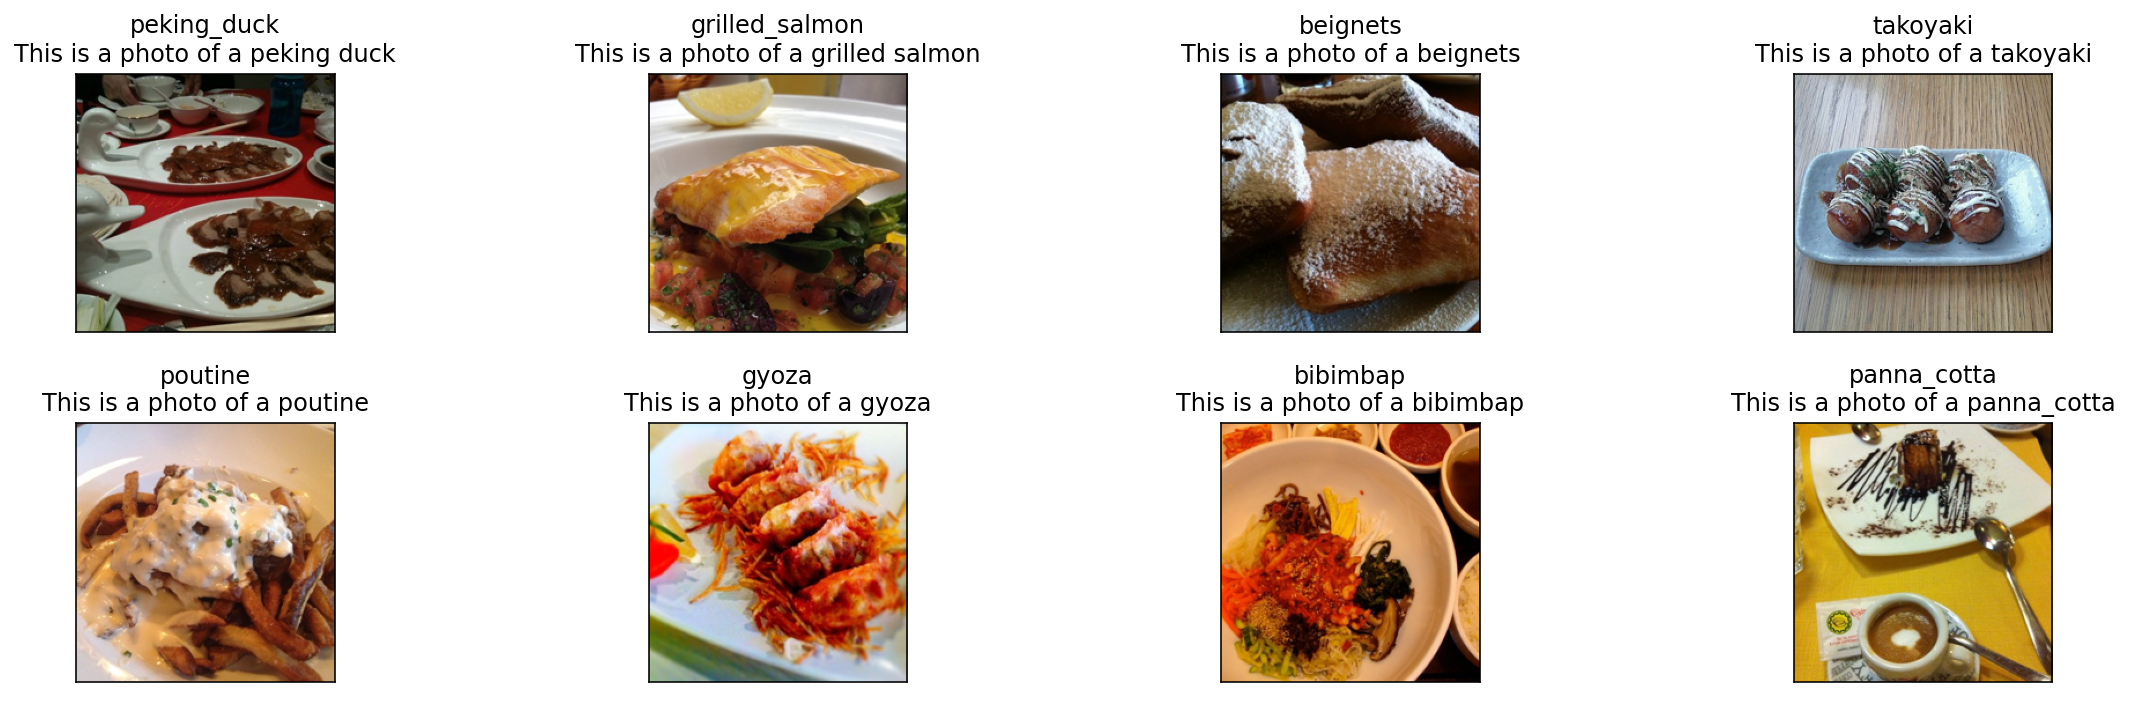

In [ ]:
images = []
texts = []
plt.figure(figsize=(16, 5))

for folder in os.listdir('food-101/train/'):
  for filename in [(i, filename) for i, filename in enumerate(os.listdir('food-101/train/' + folder )) if filename.endswith(".png") or filename.endswith(".jpg") and i == 0]:
    if folder not in descriptions:
      continue
    image = preprocess(Image.open(os.path.join('food-101/train', folder, filename[1])).convert("RGB"))
    images.append(image)
    texts.append(descriptions[folder])

    plt.subplot(2, 4, len(images))
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{folder}\n{descriptions[folder]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [ ]:
# image_input = torch.tensor(np.stack(images))
image_input = torch.tensor(np.stack(images))
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]


In [ ]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input

In [ ]:
len(text_input)

8

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

In [ ]:
text_features

tensor([[ 0.1422,  0.4325,  0.2194,  ...,  0.2329,  0.1253, -0.3861],
        [-0.1160, -0.2710, -0.0824,  ...,  0.2178, -0.6277, -0.2809],
        [ 0.4222,  0.0728, -0.0792,  ...,  0.3546, -0.5176, -0.2816],
        ...,
        [-0.0448,  0.2640, -0.0409,  ...,  0.1801, -0.0360,  0.1130],
        [-0.0247,  0.3225, -0.0435,  ...,  0.1613, -0.1672, -0.8678],
        [-0.0748,  0.0339,  0.1551,  ...,  0.2453, -0.2370,  0.0540]])

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
text_features

tensor([[ 0.0168,  0.0510,  0.0259,  ...,  0.0275,  0.0148, -0.0455],
        [-0.0132, -0.0309, -0.0094,  ...,  0.0248, -0.0716, -0.0320],
        [ 0.0498,  0.0086, -0.0093,  ...,  0.0418, -0.0611, -0.0332],
        ...,
        [-0.0054,  0.0315, -0.0049,  ...,  0.0215, -0.0043,  0.0135],
        [-0.0030,  0.0385, -0.0052,  ...,  0.0193, -0.0200, -0.1037],
        [-0.0079,  0.0036,  0.0164,  ...,  0.0259, -0.0251,  0.0057]])

Text(0.5, 1.0, 'Cosine similarity between text and image features')

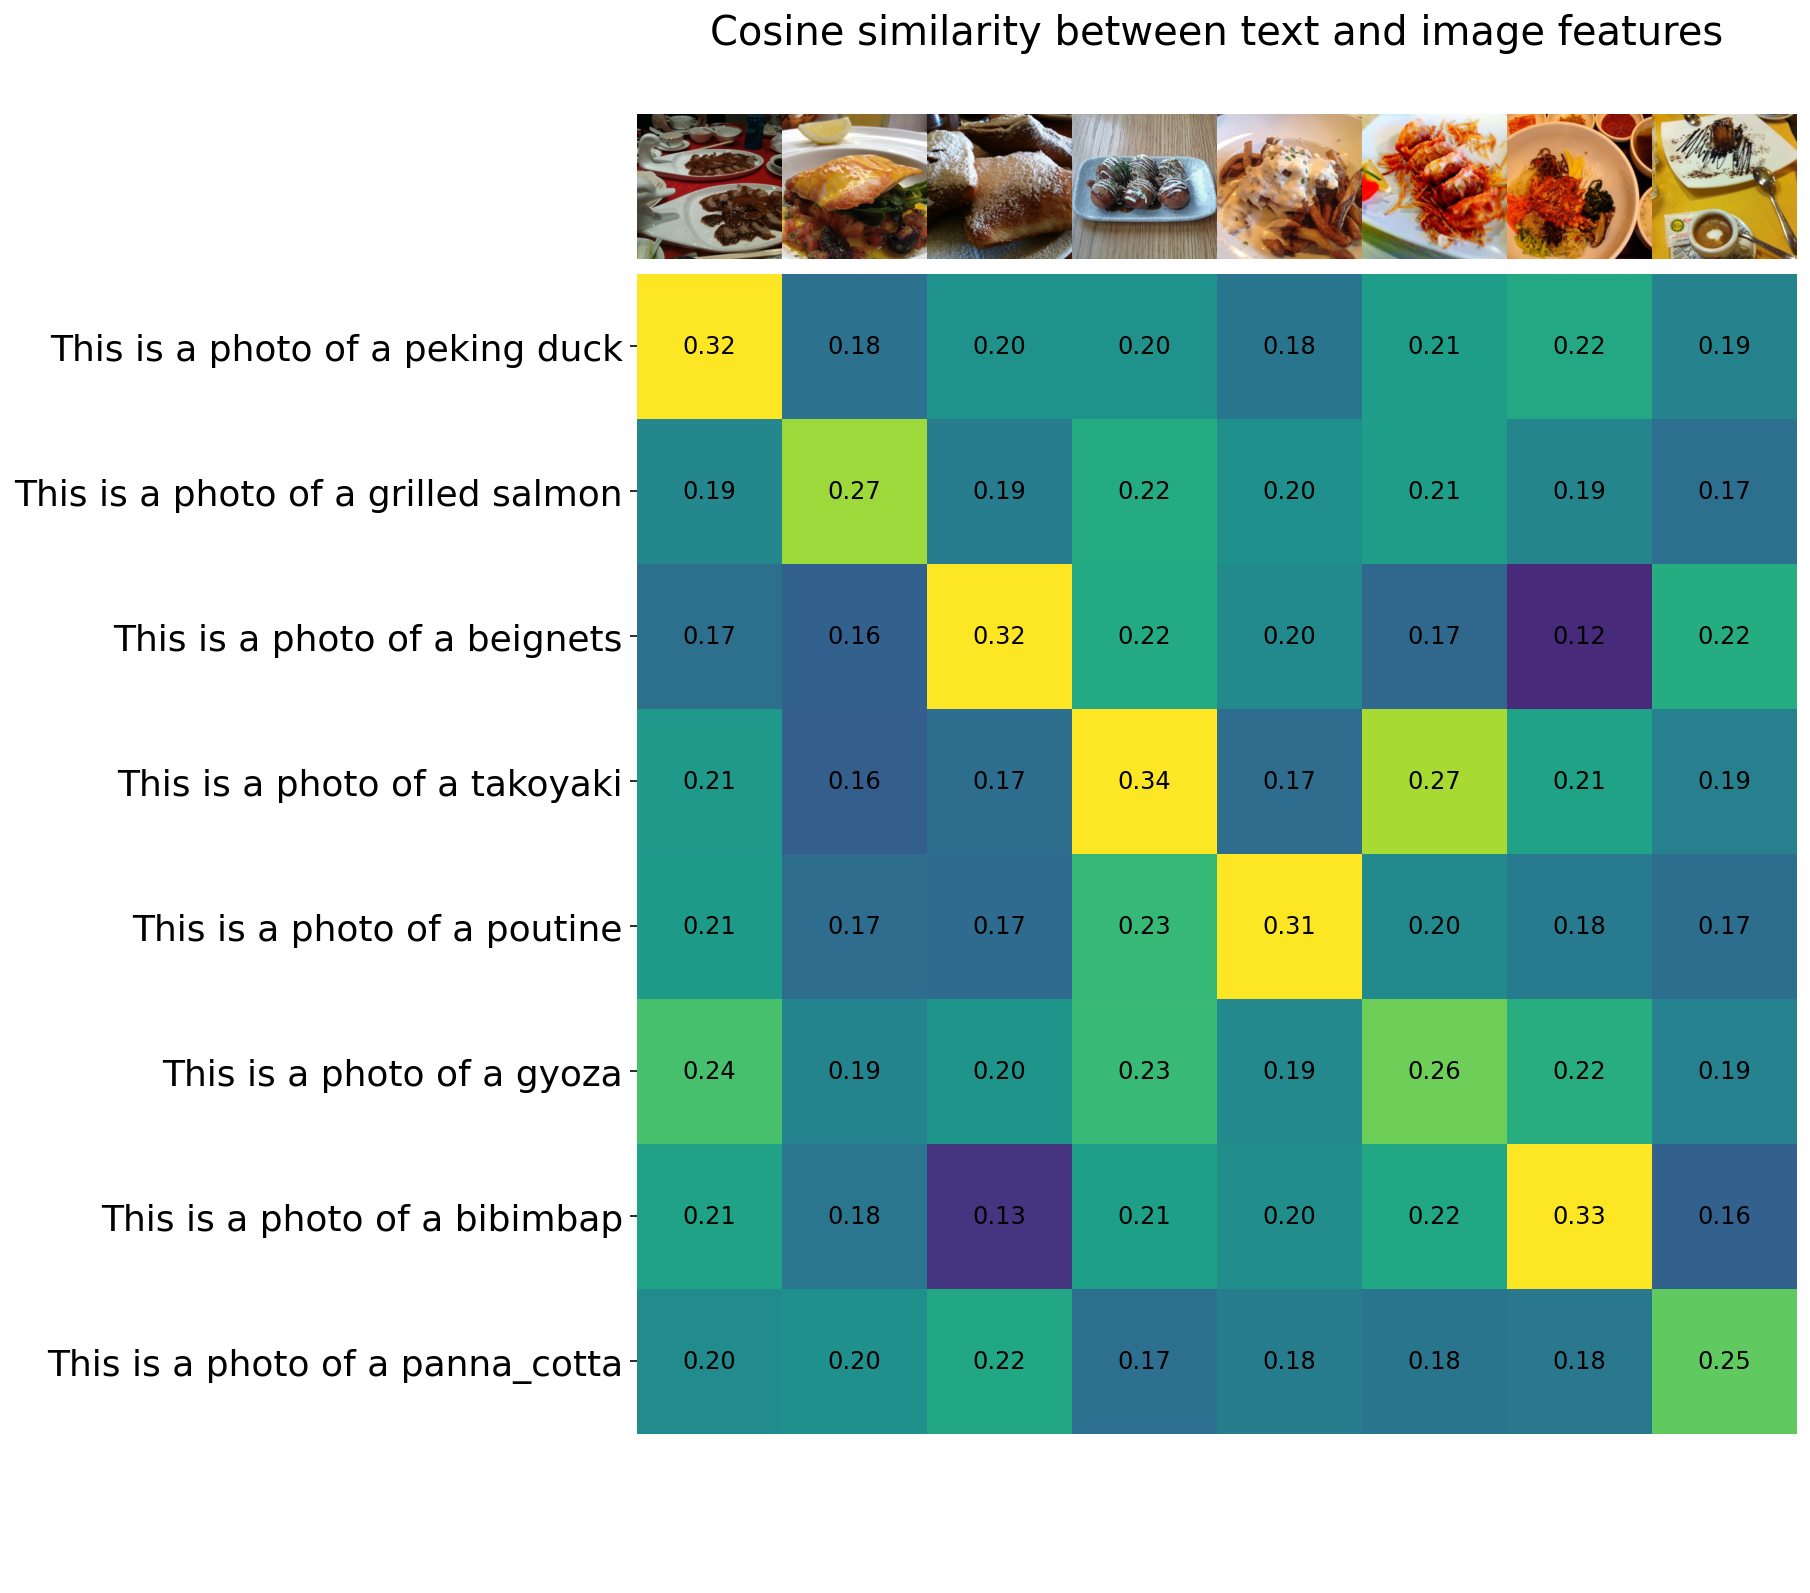

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets

# train_transforms = transforms.Compose([
#     transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
#     transforms.CenterCrop(input_resolution),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.48145466, 0.4578275, 0.40821073],
#         std=[0.26862954, 0.26130258, 0.27577711]
#     )
# ])

# valid_transforms = transforms.Compose([
#     transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
#     transforms.CenterCrop(input_resolution),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.48145466, 0.4578275, 0.40821073],
#         std=[0.26862954, 0.26130258, 0.27577711]
#     )
# ])

train_transforms = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.CenterCrop(input_resolution),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_transforms = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.CenterCrop(input_resolution),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])



In [ ]:
DIR_DATA = 'food-101/'
train_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'train'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'test'), transform=valid_transforms)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

class_names = train_data.classes

In [ ]:
candidate_captions = train_data.classes
class_names = train_data.classes

In [ ]:
master_class = class_names + texts

In [ ]:
# text_descriptions = [f"This is a photo of a {label}" for label in train_data.classes]
text_descriptions = [f"This is a photo of a {label}" for label in master_class]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input
text_input.shape

torch.Size([109, 77])

In [ ]:
# text_descriptions = [f"This is a photo of a {label}" for label in dictionary.values()]
# text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
# text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

# for i, tokens in enumerate(text_tokens):
#     text_input[i, :len(tokens)] = torch.tensor(tokens)

# text_input = text_input
# text_input.shape

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
# with torch.no_grad():
#     text_features = model.encode_text(text_input).float()
#     text_features /= text_features.norm(dim=-1, keepdim=True)

# text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
top_labels

tensor([[ 74, 101,  32,  77,   1],
        [ 50, 102,  39,  38,  99],
        [  6, 103,  12,  42,  23],
        [ 97, 104,  10,  13,  92],
        [ 78, 105,  40,  38,  66],
        [ 92,  97,  43,  70,  20],
        [  7, 107,  54,  81,  75],
        [ 21,  22,  98,  29,  73]])

In [ ]:
topk=(1,5)

In [ ]:
logits = (100.0 * image_features.float() @ text_features.T).softmax(dim=-1)
top_probs, pred = logits.topk(max(topk), 1, True, True)

In [ ]:
prediction = pred.t()

In [ ]:
correct = prediction.eq(target.view(1, -1).expand_as(prediction))

In [ ]:
top_probs = top_probs.t()
pred = pred.t()

In [ ]:
prediction = [idx for idx in pred]
probabilities = [prob for prob in top_probs]

In [ ]:
classes_test = [train_data.classes[idx] for idx in prediction[0].numpy()]
probability_test = [i for i in probabilities[0].numpy()]

IndexError: ignored

In [ ]:
import pandas as pd
df = pd.DataFrame({'Prediction':classes_test, 'Probability':probability_test})

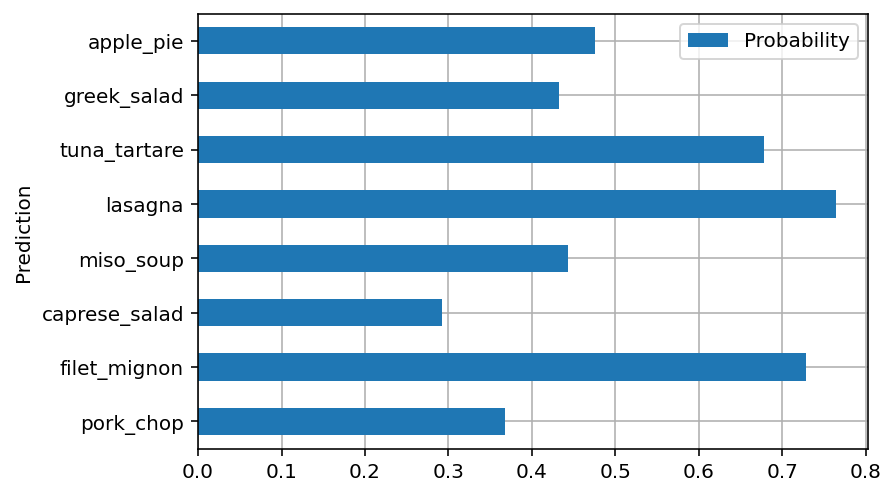

In [ ]:
ax = df.plot.barh(x='Prediction', y='Probability')
ax.grid()
ax.invert_yaxis()
ax.set_axisbelow(True)

In [ ]:
import seaborn as sns
ax = sns.barplot(x='Prediction', y='Probability', data=df, orient = 'h')
ax.set_xlabel('Prediction')

TypeError: ignored

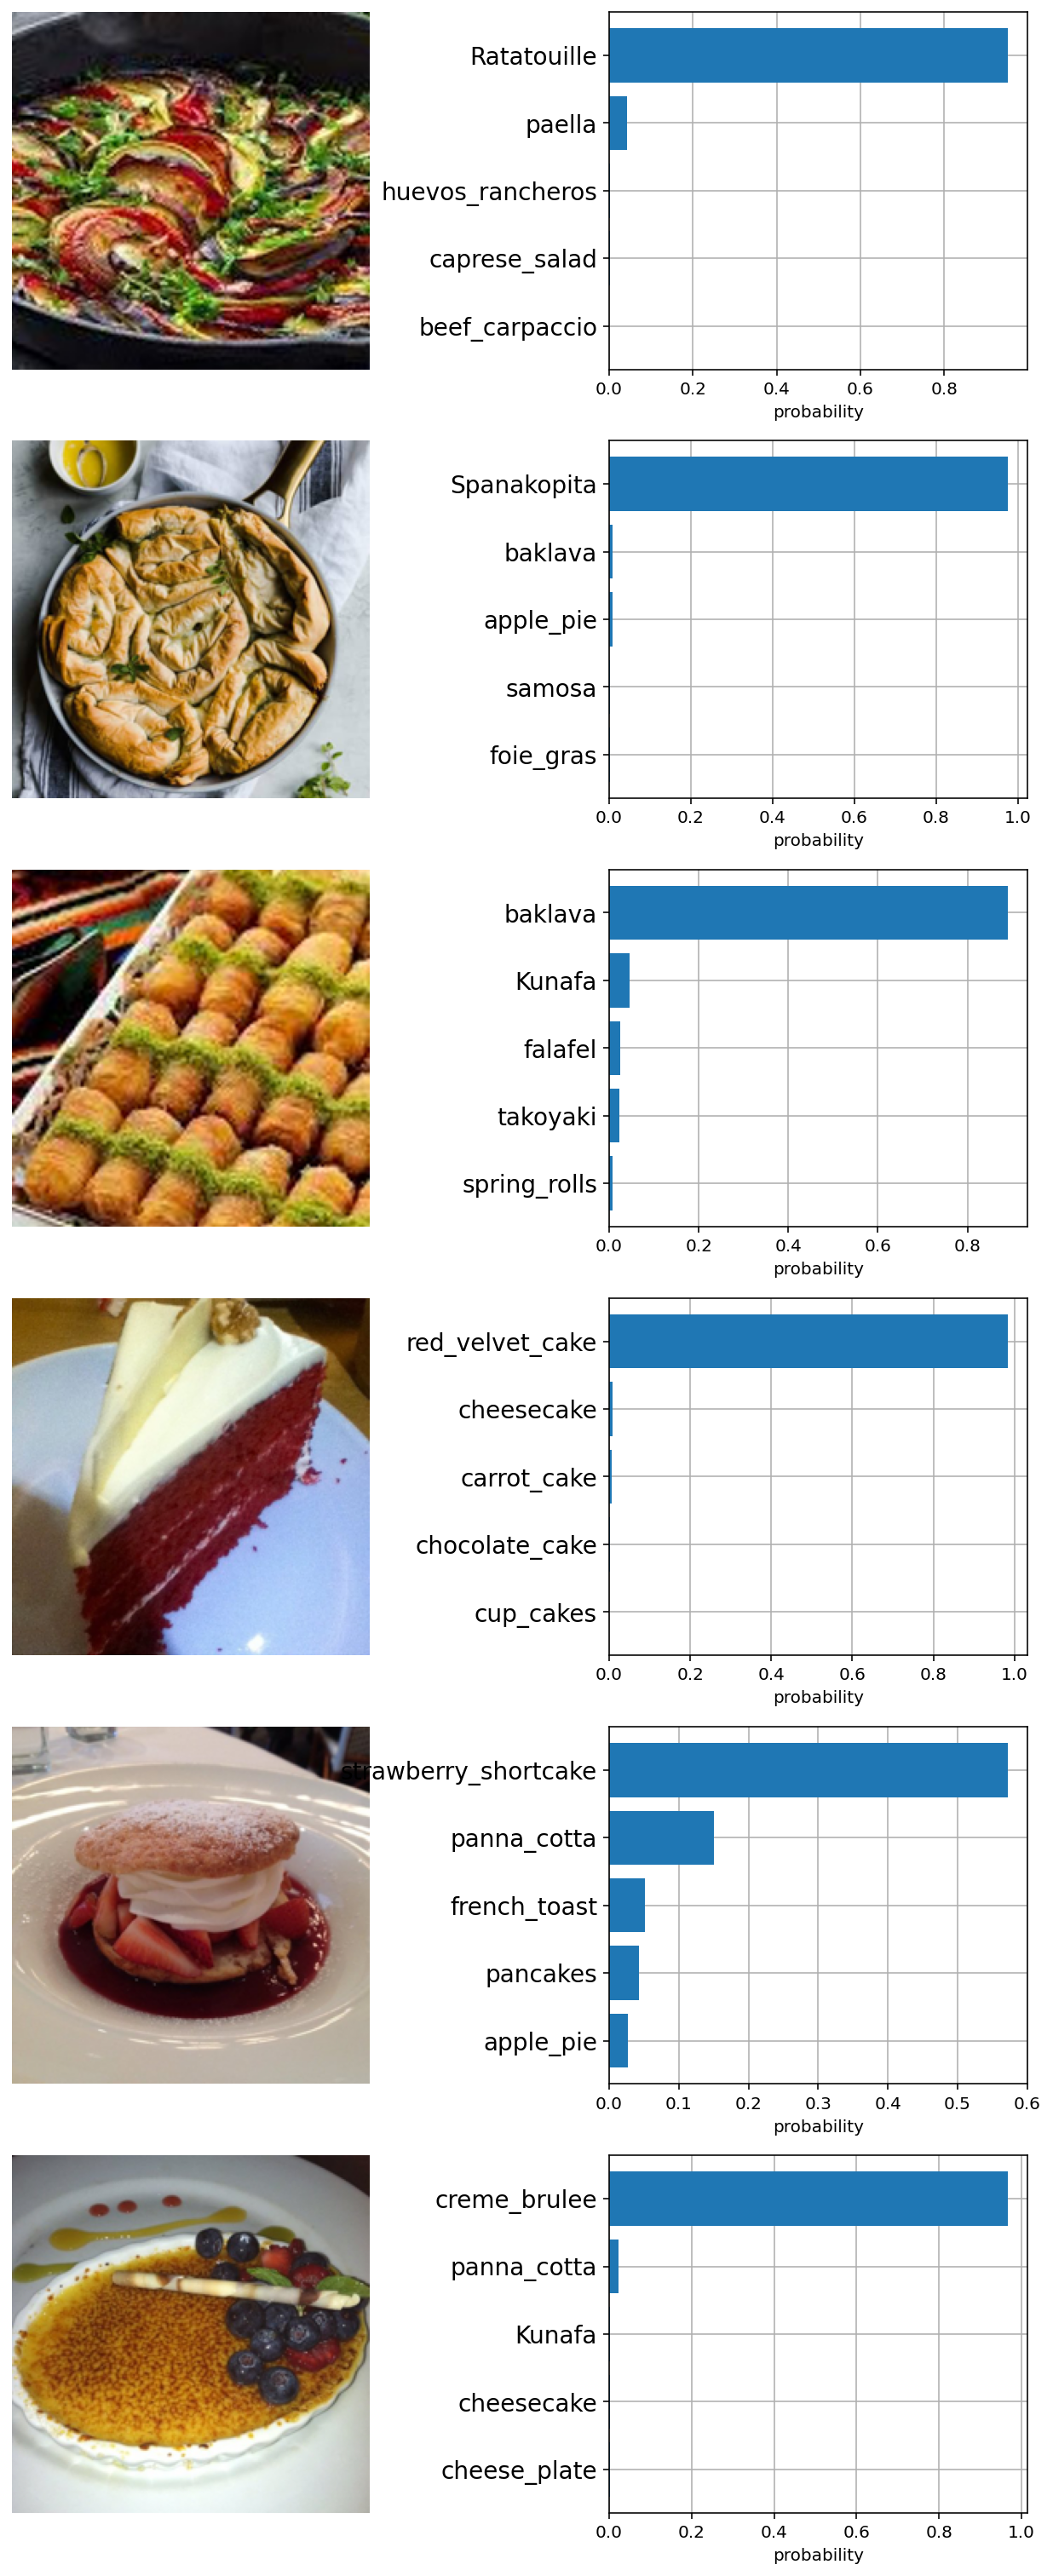

In [ ]:
plt.figure(figsize=(11, 27))

# for i, image in enumerate(images):
  
for i, image in enumerate(imagez):
    plt.subplot(6, 2, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(6, 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    # plt.yticks(y, [train_data.classes[index] for index in top_labels[i].numpy()])
    plt.yticks(y, [master_class[index] for index in top_labels[i].numpy()])
    plt.yticks(fontsize=14)
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
    food101_templates = [
        "a recipe of my {}",
        "a low resolution photo of the {}.",
        "a bad photo of the {}.",
        "a cropped photo of the {}.",
        "a bright photo of a {}.",
        "a photo of my {}.",
        "a photo of a delicious {}.",
        "a close-up photo of a {}.",
        "a pixelated photo of the {}.",
        "a bright photo of the {}.",
        "a cropped photo of a {}.",
        "a blurry photo of the {}.",
        "a photo of the {}.",
        "a good photo of the {}.",
        "a close-up photo of the {}.",
        "a photo of a {}.",
        "a low resolution photo of a {}.",
        "a photo of a large {}.",
        "a photo of a nice {}.",
        "a photo of a weird {}.",
        "a blurry photo of a {}.",
        "a pixelated photo of a {}.",
        "a good photo of a {}.",
        "a photo of the nice {}.",
        "a photo of the small {}.",
        "a photo of the weird {}.",
        "a photo of the large {}.",
        "a photo of a small {}.",
        "a photo of a baked {}.",
        "The {} was a bit salty.",
    ]

In [ ]:
food101_templates

['a recipe of my {}',
 'a low resolution photo of the {}.',
 'a bad photo of the {}.',
 'a cropped photo of the {}.',
 'a bright photo of a {}.',
 'a photo of my {}.',
 'a photo of a delicious {}.',
 'a close-up photo of a {}.',
 'a pixelated photo of the {}.',
 'a bright photo of the {}.',
 'a cropped photo of a {}.',
 'a blurry photo of the {}.',
 'a photo of the {}.',
 'a good photo of the {}.',
 'a close-up photo of the {}.',
 'a photo of a {}.',
 'a low resolution photo of a {}.',
 'a photo of a large {}.',
 'a photo of a nice {}.',
 'a photo of a weird {}.',
 'a blurry photo of a {}.',
 'a pixelated photo of a {}.',
 'a good photo of a {}.',
 'a photo of the nice {}.',
 'a photo of the small {}.',
 'a photo of the weird {}.',
 'a photo of the large {}.',
 'a photo of a small {}.',
 'a photo of a baked {}.',
 'The {} was a bit salty.']

In [ ]:
with torch.no_grad():
    zeroshot_weights = []
    # for classname in class_names:
    for classname in classes_289:
      texts = [
            template.format(classname) for template in food101_templates
        ]  # format with class
      texts = clip.tokenize(texts).to('cpu')  # tokenize
      class_embeddings = model.encode_text(texts)  # embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to('cpu')

In [ ]:
zeroshot_weights_for_cpu = zeroshot_weights.cpu().numpy()
np.save('/content/drive/My Drive/new_labels_289', zeroshot_weights_for_cpu)

NameError: ignored

In [ ]:
# import json
# class_names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/updated_labels_218.csv', encoding='utf-8')

In [ ]:
exotic_dishes = list(df['0'])
exotic_dishes

['Kunāfah',
 'Peri Peri Chicken',
 'Pastilla',
 'Shawarma',
 'Brik',
 'Injera',
 'Qatayef',
 'Alexandrian Liver (Kebda Eskandarani)',
 'Msemen',
 'Suya',
 'Nyama choma',
 'Kitfo',
 'Matbucha',
 'Grid Cakes (Roosterkoek)',
 'Milk Tart (Melktert)',
 'Hawawshi',
 'Moroccan Flatbread (Khobz)',
 'Harsha',
 'Mooncake',
 'Shaobing',
 'Chinese Crullers (Youtiao)',
 'Beijing Duck (Peking Duck)',
 'Egg Tart',
 'Chinese BBQ Pork (Char siu)',
 'Egg Roll',
 'Chinese Steamed Bun (Mantou)',
 'Siu yuk',
 'Soy Sauce Chicken',
 'Roast Squab',
 'Xianbing',
 "Beggar's Chicken",
 'Croissant',
 'Macarons',
 'Quiche',
 'Baguette',
 'Éclair (Choux)',
 'Soufflé',
 'Ratatouille',
 'Brioche',
 'Profiterole (Choux)',
 'Châteaubriand',
 'Gratin',
 'Croque-monsieur',
 'French Onion Soup (Soupe à l’oignon)',
 'Madeleines',
 'Chocolate Soufflé (Soufflé au chocolat)',
 'Pain perdu',
 'Quiche Lorraine',
 'Escargot',
 'Paris-Brest',
 'Pain au chocolat',
 'Clafoutis',
 'Quiche au fromage',
 'French Butter Cookie (Sablé)'

In [ ]:
import json
with open('/content/drive/My Drive/modified_labels_289.json', 'w') as outfile:
    json.dump('/content/drive/My Drive/updated_labels_218.json', outfile)

In [ ]:
import json
with open('/content/drive/My Drive/modified_labels_289.json', "r") as f:
  classes_289 = json.load(f)

In [ ]:
# ls

bpe_simple_vocab_16e6.txt.gz  food101_classes.json  model-card.md     setup.py
clip/                         food-101.tar.gz       notebooks/        tests/
CLIP.png                      LICENSE               README.md
food-101/                     MANIFEST.in           requirements.txt


# 5. Obtain overall predictions.

In [ ]:
import torch
import clip
from PIL import Image
from tqdm import tqdm

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, preprocess = clip.load("ViT-B/32", device=device) #loading the clip checkpoints

data_dir = r'/content/CLIP/food-101'

train_data = datasets.ImageFolder(data_dir + r'/train', transform=preprocess)
test_data = datasets.ImageFolder(data_dir + r'/test', transform=preprocess)

torch.manual_seed(42)

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [ ]:
# train_features, train_labels = get_features(train_data)
test_features, test_labels = get_features(test_data)

100%|██████████| 253/253 [38:01<00:00,  9.02s/it]


In [ ]:
# Create a temporary variable, image_features, to store the images
# processed through the 
image_features = test_features

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in train_data.classes]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input
text_input.shape

torch.Size([101, 77])

In [ ]:
text_descriptions = [label for label in dictionary.values()]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input
text_input.shape

torch.Size([101, 77])

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_input).float()

In [ ]:
image_features = torch.from_numpy(image_features)

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
#text_features = zeroshot_weights

In [ ]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

In [ ]:
pred = top_labels.t()
target = torch.from_numpy(test_labels)

In [ ]:
target

tensor([  0,   0,   0,  ..., 100, 100, 100])

In [ ]:
correct = pred.eq(target.view(1, -1).expand_as(pred))

In [ ]:
correct

tensor([[False,  True,  True,  ..., False,  True,  True],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False]])

In [ ]:
topk = (1,53)

In [ ]:
res = []
for k in topk:
  correct_k = correct[:k].reshape(-1).float().sum(0)
  res.append(correct_k.mul_(100.0 / batch_size))

In [ ]:
testing = torch.stack(res)

In [ ]:
res.data[1].item()

AttributeError: ignored

In [ ]:
top5 = res.item()[1]

AttributeError: ignored

In [ ]:
res

[tensor(81.1644), tensor(93.7069)]

In [ ]:
res

[tensor(81.1644), tensor(81.1644)]

In [ ]:
predictions = np.concatenate(top_labels.numpy())
acc = np.mean(predictions == test_labels)
print(f'Overall accuracy for full dataset is {acc}'.format(acc))

Overall accuracy for full dataset is 0.8116435643564357


In [ ]:
image_list = [idx for idx, t in enumerate(dictionary.keys()) ]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
test_labels = image_list

In [ ]:
test_labels = np.array(test_labels)
test_labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
predictions

array([ 85,   0,   0, ...,  94, 100, 100])

In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(test_labels, predictions)
print(conf_mat)

ValueError: ignored

In [ ]:
# %load_ext google.colab.data_table
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = list(train_data.classes)
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(int)
df_cm
# heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
# heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
# heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# ;

apple_pie  baby_back_ribs  ...  tuna_tartare  waffles
apple_pie                      167               0  ...             0        1
baby_back_ribs                   0             208  ...             0        0
baklava                         10               0  ...             0        0
beef_carpaccio                   0               0  ...             7        0
beef_tartare                     0               0  ...            30        0
beet_salad                       1               0  ...             1        0
beignets                         1               0  ...             0        0
bibimbap                         0               0  ...             0        0
bread_pudding                    4               0  ...             0        1
breakfast_burrito                1               0  ...             0        0
bruschetta                       0               0  ...             4        1
caesar_salad                     0               0  ...             0        0
cannoli                          0               0  ...             0        0
caprese_salad                    0               0  ...             2        0
carrot_cake                      1               0  ...             0        0
ceviche                          0               0  ...             5        0
cheese_plate                     0               0  ...             1        0
cheesecake                       2               0  ...             0        0
chicken_curry                    1               0  ...             0        0
chicken_quesadilla               0               0  ...             0        0
chicken_wings                    0               8  ...             0        0
chocolate_cake                   0               0  ...             0        0
chocolate_mousse                 1               0  ...             0        0
churros                          1               0  ...             0        2
clam_chowder                     1               0  ...             0        0
club_sandwich                    0               0  ...             0        0
crab_cakes                       0               0  ...             2        0
creme_brulee                     2               0  ...             0        0
croque_madame                    0               0  ...             0        0
cup_cakes                        0               0  ...             0        0
deviled_eggs                     0               0  ...             0        0
donuts                           0               0  ...             0        0
dumplings                        0               0  ...             0        0
edamame                          0               0  ...             0        0
eggs_benedict                    0               0  ...             0        1
escargots                        0               0  ...             1        0
falafel                          0               0  ...             0        0
filet_mignon                     0               2  ...             0        0
fish_and_chips                   0               0  ...             0        0
foie_gras                        1               0  ...             4        0
french_fries                     0               0  ...             0        0
french_onion_soup                0               0  ...             0        0
french_toast                     1               1  ...             0        1
fried_calamari                   0               0  ...             0        1
fried_rice                       0               0  ...             0        0
frozen_yogurt                    0               0  ...             0        0
garlic_bread                     1               0  ...             0        0
gnocchi                          0               0  ...             0        0
greek_salad                      0               0  ...             2        0
grilled_cheese_sandwich          1               0  ...             0      

<Figure size 2160x1440 with 0 Axes>

In [ ]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[66.8 83.2 83.6 81.6 74.4 61.6 76.  95.2 83.6 71.2 73.6 88.  90.  87.2
 87.2 68.4 90.8 61.6 80.8 89.6 87.2 74.4 72.4 83.6 84.8 94.8 74.8 93.6
 82.  88.4 90.  94.8 88.  83.6 96.  81.2 75.6 37.2 90.  68.8 92.4 86.
 66.8 89.6 83.6 96.4 70.4 52.  82.8 62.8 81.2 82.4 80.8 60.4 92.  87.6
 87.2 71.2 64.8 74.  87.6 94.8 74.4 92.8 86.8 90.4 92.8 74.4 76.8 99.2
 95.2 91.2 91.6 86.8 80.8 89.6 96.4 57.6 87.6 77.6 92.4 79.6 40.4 82.
 78.  80.4 90.8 55.6 95.2 88.  96.  93.6 87.6 52.4 76.8 87.6 83.6 85.2
 72.4 63.6 92. ]


In [ ]:
df_acc = pd.DataFrame(class_accuracy, index=class_names, columns=['Accuracy_Score']).astype(float)
df_acc.sort_values(by ='Accuracy_Score')

Accuracy_Score
filet_mignon                       37.2
ravioli                            40.4
gnocchi                            52.0
steak                              52.4
scallops                           55.6
pork_chop                          57.6
hamburger                          60.4
beet_salad                         61.6
cheesecake                         61.6
grilled_cheese_sandwich            62.8
tuna_tartare                       63.6
ice_cream                          64.8
apple_pie                          66.8
french_toast                       66.8
ceviche                            68.4
foie_gras                          68.8
garlic_bread                       70.4
breakfast_burrito                  71.2
hummus                             71.2
tiramisu                           72.4
chocolate_mousse                   72.4
bruschetta                         73.6
lasagna                            74.0
beef_tartare                       74.4
macaroni_and_cheese                74.4
chocolate_cake                     74.4
omelette                           74.4
crab_cakes                         74.8
falafel                            75.6
beignets                           76.0
onion_rings                        76.8
strawberry_shortcake               76.8
prime_rib                          77.6
risotto                            78.0
ramen                              79.6
samosa                             80.4
chicken_curry                      80.8
gyoza                              80.8
peking_duck                        80.8
grilled_salmon                     81.2
escargots                          81.2
beef_carpaccio                     81.6
croque_madame                      82.0
red_velvet_cake                    82.0
guacamole                          82.4
greek_salad                        82.8
baby_back_ribs                     83.2
fried_rice                         83.6
churros                            83.6
edamame                            83.6
baklava                            83.6
tacos                              83.6
bread_pudding                      83.6
clam_chowder                       84.8
takoyaki                           85.2
french_onion_soup                  86.0
panna_cotta                        86.8
miso_soup                          86.8
carrot_cake                        87.2
huevos_rancheros                   87.2
chicken_wings                      87.2
caprese_salad                      87.2
poutine                            87.6
spring_rolls                       87.6
hot_dog                            87.6
lobster_bisque                     87.6
sushi                              87.6
dumplings                          88.0
shrimp_and_grits                   88.0
caesar_salad                       88.0
cup_cakes                          88.4
pho                                89.6
fried_calamari                     89.6
chicken_quesadilla                 89.6
deviled_eggs                       90.0
cannoli                            90.0
fish_and_chips                     90.0
mussels                            90.4
cheese_plate                       90.8
sashimi                            90.8
paella                             91.2
pancakes                           91.6
hot_and_sour_soup                  92.0
waffles                            92.0
french_fries                       92.4
pulled_pork_sandwich               92.4
nachos                             92.8
macarons                           92.8
spaghetti_carbonara                93.6
creme_brulee                       93.6
lobster_roll_sandwich              94.8
club_sandwich                      94.8
donuts                             94.8
bibimbap                           95.2
seaweed_salad                      95.2
pad_thai                           95.2
spaghetti_bolognese                96.0
eggs_benedict                      96.0
pizza                              96.4
frozen_yogurt            

In [ ]:
! pip install pycm

In [ ]:
from pycm import *
cm=ConfusionMatrix(actual_vector=test_labels,predict_vector=predictions)
cm.stat(summary=True)


Overall Statistics : 

ACC Macro                                                         0.99627
F1 Macro                                                          0.81013
FPR Macro                                                         0.00188
Kappa                                                             0.80976
Overall ACC                                                       0.81164
PPV Macro                                                         0.82208
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.81164
Zero-one Loss                                                     4756

Class Statistics :

Classes                                                           0             1             2             3             4             5             6             7             8             9             10            11            12            13            14            15        

/usr/local/lib/python3.6/dist-packages/pycm/pycm_obj.py:182: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


# 6. Linear probe testing. Still not ready for implementation


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# path = F"/content/gdrive/My Drive/CLIP_Food101_processed_tensors" 

In [ ]:

# CLIP_Food101 = {'train_features': train_features, 
#                 'train_labels': train_labels,
#                 'val_features':val_features, 
#                 'val_labels': val_labels}
# torch.save(CLIP_Food101, path)

In [ ]:
# path = F"/content/gdrive/My Drive/CLIP_Food101_processed_tensors" 
# loaded = torch.load(path)
# train_features = loaded['train_features']
# train_labels = loaded['train_labels'] 
# val_features = loaded['val_features']
# val_labels = loaded['val_labels']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
space = dict()
space['solver'] = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
space['penalty'] = ['l2', 'l1', 'elasticnet']
space['C'] = [10, 12, 14]

search = RandomizedSearchCV(model, space, n_iter=250, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(val_features, val_labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 45 is smaller than n_iter=250. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Score: 0.8720000000000001
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12}


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#Evaluate L1 regularization strengths for reducing features in final model 
C = [12,11,10] # As C decreases, more coefficients go to zero

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear', class_weight="balanced")
    # using data before splitting (X_scaled) and (y)
    scores = cross_val_score(clf, test_features, test_labels, cv=5, scoring="accuracy")  #<-- add this
    print(scores)  #<-- add this

[0.87089109 0.87623762 0.86534653 0.87861386 0.87207921]
[0.87168317 0.87564356 0.86475248 0.87762376 0.87227723]
[0.87128713 0.87584158 0.86475248 0.8760396  0.87247525]


In [ ]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression
# *Note that the C value should be determined via a hyperparameter sweep using a validation split.
classifier = LogisticRegression(random_state=0, C=10, verbose=1, solver='liblinear', penalty='l2')
classifier.fit(train_features, train_labels)

[LibLinear]

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 30.634


In [ ]:
np.mean((test_labels == predictions))

0.28467326732673265

In [ ]:
np.mean(predictions == test_labels)

0.009900990099009901

In [ ]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(val_labels, predictions)
print(conf_mat)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# %load_ext google.colab.data_table
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(30,20))

class_names = list(train_data.classes)
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(int)
df_cm

apple_pie  baby_back_ribs  ...  tuna_tartare  waffles
apple_pie                        0               0  ...             0        0
baby_back_ribs                   0               0  ...             0        0
baklava                          0               0  ...             0        0
beef_carpaccio                   0               0  ...             0        0
beef_tartare                     0               0  ...             0        0
beet_salad                       0               0  ...             0        0
beignets                         0               0  ...             0        0
bibimbap                         0               0  ...             0        0
bread_pudding                    0               0  ...             0        0
breakfast_burrito                0               0  ...             0        0
bruschetta                       0               0  ...             0        0
caesar_salad                     0               0  ...             0        0
cannoli                          0               0  ...             0        0
caprese_salad                    0               0  ...             0        0
carrot_cake                      0               0  ...             0        0
ceviche                          0               0  ...             0        0
cheese_plate                     0               0  ...             0        0
cheesecake                       0               0  ...             0        0
chicken_curry                    0               0  ...             0        0
chicken_quesadilla               0               0  ...             0        0
chicken_wings                    0               0  ...             0        0
chocolate_cake                   0               0  ...             0        0
chocolate_mousse                 0               0  ...             0        0
churros                          0               0  ...             0        0
clam_chowder                     0               0  ...             0        0
club_sandwich                    0               0  ...             0        0
crab_cakes                       0               0  ...             0        0
creme_brulee                     0               0  ...             0        0
croque_madame                    0               0  ...             0        0
cup_cakes                        0               0  ...             0        0
deviled_eggs                     0               0  ...             0        0
donuts                           0               0  ...             0        0
dumplings                        0               0  ...             0        0
edamame                          0               0  ...             0        0
eggs_benedict                    0               0  ...             0        0
escargots                        0               0  ...             0        0
falafel                          0               0  ...             0        0
filet_mignon                     0               0  ...             0        0
fish_and_chips                   0               0  ...             0        0
foie_gras                        0               0  ...             0        0
french_fries                     0               0  ...             0        0
french_onion_soup                0               0  ...             0        0
french_toast                     0               0  ...             0        0
fried_calamari                   0               0  ...             0        0
fried_rice                       0               0  ...             0        0
frozen_yogurt                    0               0  ...             0        0
garlic_bread                     0               0  ...             0        0
gnocchi                          0               0  ...             0        0
greek_salad                      0               0  ...             0        0
grilled_cheese_sandwich          0               0  ...             0      

<Figure size 2160x1440 with 0 Axes>

In [ ]:
dictionary = {'apple_pie' : 'This is a photo of an apple_pie, a type of dessert',
              'baby_back_ribs': 'This is a photo of baby back ribs, a type of a type of beef',
              'baklava': 'This is a photo of baklava, a type of greek dessert',
              'beef_carpaccio': 'This is a photo of beef carpaccio, raw beef sliced paper-thin',
              'beef_tartare': 'This is a photo of beef tartare, a meat dish from raw ground minced beef',
              'beet_salad': 'This is a photo of beet salad, a type of beetroot red vegetable',
              'beignets': 'This is a photo of a beignets, a type of fritter',
              'bibimbap': 'This is a photo of a bibimbap, a type of Korean rice dish',
              'bread_pudding': 'This is a photo of a bread pudding, a type of bread based dessert',
              'breakfast_burrito': 'This is a photo of a breakfast burrito, a type of wrap with eggs',
              'bruschetta': 'This is a photo of a bruschetta, a type of an antipasto from Italy',
              'caesar_salad': 'This is a photo of a ceasar salad, a type of a green salad',
              'cannoli': 'This is a photo of a cannoli, Italian tube-shaped pastries',
              'caprese_salad': 'This is a photo of a caprese_salad, a simple Italian salad',
              'carrot_cake': 'This is a photo of a carrot cake, a type of dessert',
              'ceviche': 'This is a photo of a ceviche, a Latin American raw fish dish',
              'cheese_plate': 'This is a photo of a cheese plate, a type of cheese platter',
              'cheesecake': 'This is a photo of a cheesecake, a type of dessert',
              'chicken_curry': 'This is a photo of a chicken curry, a type of Indian dish',
              'chicken_quesadilla': 'This is a photo of a chicken quesadilla, a type of American Mexican dish',
              'chicken_wings': 'This is a photo of a chicken wing, a type of deep fried American dish',
              'chocolate_cake': 'This is a photo of a chocolate cake , a type of dessert',
              'chocolate_mousse': 'This is a photo of a chocolate mousse , a type of French dessert',
              'churros': 'This is a photo of churros, a type of fried dough pastry',
              'clam_chowder': 'This is a photo of a clam chowder, a type of soup',
              'club_sandwich': 'This is a photo of a club sandwich, also called a clubhouse sandwich',
              'crab_cakes': 'This is a photo of a crab cake , a variety of fishcake',
              'creme_brulee': 'This is a photo of a creme brulee, a type of french dessert',
              'croque_madame': 'This is a photo of a croque madame, a type of hot sandwich',
              'cup_cakes': 'This is a photo of a cup cake, a type of small cake',
              'deviled_eggs': 'This is a photo of a devilled eggs, a type of stuffed eggs',
              'donuts': 'This is a photo of donuts, a type of fried dough confection',
              'dumplings': 'This is a photo of dumplings, a type of chineese dish',
              'edamame': 'This is a photo of edemame, a type of soybean',
              'eggs_benedict': 'This is a photo of eggs benedict, an American breakfast dish',
              'escargots': 'This is a photo of escargots, a type of land snail dish',
              'falafel': 'This is a photo of a falafel, a type of deep fried ball',
              'filet_mignon': 'This is a photo of a filet mignon, a fancy, tender cut from the short loin',
              'fish_and_chips': 'This is a photo of fish and chips, a hot dish from England',
              'foie_gras': 'This is a photo of foie gras, a specialty food product made of liver',
              'french_fries': 'This is a photo of french fries, o type of fried potatoes',
              'french_onion_soup': 'This is a photo of a french onion soup, a type of French soup',
              'french_toast': 'This is a photo of a french toast, a dish made of sliced bread',
              'fried_calamari': 'This is a photo of a fried calamari, type of fried seafood',
              'fried_rice': 'This is a photo of fried rice, dish of stir-fried rice',
              'frozen_yogurt': 'This is a photo of a frozen yogurt, a type of frozen dessert',
              'garlic_bread': 'This is a photo of a garlic bread, a type of bread',
              'gnocchi': 'This is a photo of a gnocchi, an italian pasta potato dumpling',
              'greek_salad': 'This is a photo of a greek salad, a type of salad',
              'grilled_cheese_sandwich': 'This is a photo of a grilled cheese sandwich, a type of toasted sandwich',
              'grilled_salmon': 'This is a photo of a grilled salmon, a type of fish fillet',
              'guacamole': 'This is a photo of a guacamole, an avocado based dip from Mexico',
              'gyoza': 'This is a photo of a gyoza, a type of Chinese dumpling',
              'hamburger': 'This is a photo of a hamburger, a beed pattie between two buns',
              'hot_and_sour_soup': 'This is a photo of a hot and sour soup, a type of Chinese food',
              'hot_dog': 'This is a photo of a hot dog, a type of steamed sausage on a sliced bun ',
              'huevos_rancheros': 'This is a photo of huevos rancheros, a breakfast Mexican dish',
              'hummus': 'This is a photo of a hummus, a Middle Eastern dip',
              'ice_cream': 'This is a photo of an ice cream, a type of frozen dessert',
              'lasagna': 'This is a photo of a lasagna, an Italian dish',
              'lobster_bisque': 'This is a photo of a lobster bisque, a French creamy soup',
              'lobster_roll_sandwich': 'This is a photo of a lobster roll sandwich, a dish from New Engalnd',
              'macaroni_and_cheese': 'This is a photo of a macaroni and cheese, a type of cheese pasta',
              'macarons': 'This is a photo of macarons, or French macaroon, a sweet meringue-based dessert',
              'miso_soup': 'This is a photo of miso soup, a traditional Japanese soup',
              'mussels': 'This is a photo of mussels, a type of seafood',
              'nachos': 'This is a photo of nachos, a type of a Mexican appetizer',
              'omelette': 'This is a photo of an omelette, a dish made from beaten eggs',
              'onion_rings': 'This is a photo of an onion ring, a form of appetizer',
              'oysters': 'This is a photo of a oysters, a type of seafood',
              'pad_thai': 'This is a photo of a pad thai, a stir-fried rice noodle from Thailand',
              'paella': 'This is a photo of a paella, a Spanish rice seafood dish',
              'pancakes': 'This is a photo of pancakes, a breakfast dish',
              'panna_cotta': 'This is a photo of a panna cotta , an Italian dessert',
              'peking_duck': 'This is a photo of a peking duck, a dish from Beijing China',
              'pho': 'This is a photo of a pho, a Vietnamese soup',
              'pizza': 'This is a photo of a pizza, a type of round Italian dish',
              'pork_chop': 'This is a photo of a pork chop, a type of meat',
              'poutine': 'This is a photo of a poutine, a dish of french fries with cheese curds and gravy',
              'prime_rib': 'This is a photo of a prime rib, a type of fancy beef cut',
              'pulled_pork_sandwich': 'This is a photo of a pulled pork sandwich, an American barbeque dish',
              'ramen': 'This is a photo of a ramen, a Japanese noodle soup',
              'ravioli': 'This is a photo of a ravioli, a type of Italian squared or circle pasta',
              'red_velvet_cake': 'This is a photo of a red velvet cake, a red layered cake with white frosting',
              'risotto': 'This is a photo of a risotto, a creamy Italan rice dish',
              'samosa': 'This is a photo of a samosa, an Indian fried pastry',
              'sashimi': 'This is a photo of a sashimi, a Japanese delicacy made of raw fish',
              'scallops': 'This is a photo of a scallops, a white pan seared shellfish served with butter and lemon',
              'seaweed_salad': 'This is a photo of a seaweed salad, a japanese salad',
              'shrimp_and_grits': 'This is a photo of shrimp and grits, a traditional American dish ',
              'spaghetti_bolognese': 'This is a photo of spaghetti bolognese, an Italian dish',
              'spaghetti_carbonara': 'This is a photo of a spaghetti carbonara, an Italian dish',
              'spring_rolls': 'This is a photo of spring rolls, a filled rolled appetizers from Asia',
              'steak': 'This is a photo of a steak, a beef tenderloin',
              'strawberry_shortcake': 'This is a photo of a strawberry shortcake, a type of dessert',
              'sushi': 'This is a photo of a sushi, a type of japanese dish',
              'tacos': 'This is a photo of tacos, a type of Mexican dish',
              'takoyaki': 'This is a photo of a takoyaki, or octopus balls, a ball-shaped Japanese snack',
              'tiramisu': 'This is a photo of a tiramisu, a type of Italian dessert',
              'tuna_tartare': 'This is a photo of a tuna tartare, a type of raw fish made of tuna',
              'waffles': 'This is a photo of a waffle, a type of breakfast dish',
              'macaron': 'This is a photo of a',
              'cruller': 'This is a photo of a',
              'cockle_food': 'This is a photo of a',
              'tostada': 'This is a photo of a',
              'moussaka': 'This is a photo of a',
              'knish': 'This is a photo of a',
              'croquette': 'This is a photo of a',
              'couscous': 'This is a photo of a',
              'porridge': 'This is a photo of a',
              'stuffed_cabbage': 'This is a photo of a',
              'chow_mein': 'This is a photo of a',
              'rigatoni': 'This is a photo of a',
              'cupcake': 'This is a photo of a',
              'osso_buco': 'This is a photo of a',
              'chicken_kiev': 'This is a photo of a',
              'fruitcake': 'This is a photo of a',
              'chop_suey': 'This is a photo of a',
              'haggis': 'This is a photo of a',
              'scrambled_eggs': 'This is a photo of a',
              'frittata': 'This is a photo of a',
              'scampi': 'This is a photo of a',
              'orzo': 'This is a photo of a',
              'fritter': 'This is a photo of a',
              'nacho': 'This is a photo of a',
              'beef_stroganoff': 'This is a photo of a',
              'beef_wellington': 'This is a photo of a',
              'savarin': 'This is a photo of a',
              'crayfish_food': 'This is a photo of a',
              'souffle': 'This is a photo of a',
              'adobo': 'This is a photo of a',
              'streusel': 'This is a photo of a',
              'farfalle': 'This is a photo of a',
              'terrine': 'This is a photo of a',
              'poached_egg': 'This is a photo of a',
              'bubble_and_squeak': 'This is a photo of a',
              'egg_roll': 'This is a photo of a',
              'sauerkraut': 'This is a photo of a',
              'pavlova': 'This is a photo of a',
              'fondue': 'This is a photo of a',
              'jambalaya': 'This is a photo of a',
              'tempura': 'This is a photo of a',
              'potpie': 'This is a photo of a',
              'sukiyaki': 'This is a photo of a',
              'applesauce': 'This is a photo of a',
              'salisbury_steak': 'This is a photo of a',
              'linguine': 'This is a photo of a',
              'coq_au_vin': 'This is a photo of a',
              'tamale': 'This is a photo of a',
              'kedgeree': 'This is a photo of a',
              'vermicelli': 'This is a photo of a',
              'pate': 'This is a photo of a',
              'tetrazzini': 'This is a photo of a',
              'compote': 'This is a photo of a',
              'lobster_food': 'This is a photo of a',
              'succotash': 'This is a photo of a',
              'lutefisk': 'This is a photo of a',
              'sloppy_joe': 'This is a photo of a',
              'gingerbread': 'This is a photo of a',
              'sauerbraten': 'This is a photo of a',
              'ham_sandwich': 'This is a photo of a',
              'crumpet': 'This is a photo of a',
              'cottage_pie': 'This is a photo of a',
              'torte': 'This is a photo of a',
              'poi': 'This is a photo of a',
              'bacon_and_eggs': 'This is a photo of a',
              'coffee_cake': 'This is a photo of a',
              'custard': 'This is a photo of a',
              'syllabub': 'This is a photo of a',
              'boiled_egg': 'This is a photo of a',
              'galantine': 'This is a photo of a',
              'brisket': 'This is a photo of a',
              'reuben': 'This is a photo of a',
              'schnitzel': 'This is a photo of a',
              'ambrosia_food': 'This is a photo of a',
              'jerky': 'This is a photo of a',
              'wonton': 'This is a photo of a',
              'enchilada': 'This is a photo of a',
              'fettuccine': 'This is a photo of a',
              'chili': 'This is a photo of a',
              'flan': 'This is a photo of a',
              'kabob': 'This is a photo of a',
              'sponge_cake': 'This is a photo of a',
              'casserole': 'This is a photo of a',
              'blancmange': 'This is a photo of a',
              'tortellini': 'This is a photo of a',
              'meat_loaf_food': 'This is a photo of a',
              'meatball': 'This is a photo of a',
              'scrapple': 'This is a photo of a',
              'strudel': 'This is a photo of a',
              'coconut_cake': 'This is a photo of a',
              'marble_cake': 'This is a photo of a',
              'fried_egg': 'This is a photo of a',
              'penne': 'This is a photo of a',
              'tenderloin': 'This is a photo of a',
              'baked_alaska': 'This is a photo of a',
              'ham_and_eggs': 'This is a photo of a',
              'biryani': 'This is a photo of a',
              'tagliatelle': 'This is a photo of a',
              'stuffed_peppers': 'This is a photo of a',
              'cannelloni': 'This is a photo of a',
              'sausage_roll': 'This is a photo of a',
              'limpet_food': 'This is a photo of a',
              'ziti': 'This is a photo of a',
              'manicotti': 'This is a photo of a',
              'waffle': 'This is a photo of a',
              'clam_food': 'This is a photo of a',
              'burrito': 'This is a photo of a',
              'roulade': 'This is a photo of a',
              'gyro': 'This is a photo of a',
              'pound_cake': 'This is a photo of a',
              'tapenade': 'This is a photo of a',
              'pepper_steak': 'This is a photo of a',
              'welsh_rarebit': 'This is a photo of a',
              'pilaf': 'This is a photo of a',
              'dolmas': 'This is a photo of a',
              'coquilles_saint_jacques': 'This is a photo of a',
              'veal_cordon_bleu': 'This is a photo of a',
              'shirred_egg': 'This is a photo of a',
              'barbecued_wing': 'This is a photo of a',
              'steak_au_poivre': 'This is a photo of a',
              'huitre': 'This is a photo of a',
              'chiffon_cake': 'This is a photo of a',
              'profiterole': 'This is a photo of a',
              'toad_in_the_hole': 'This is a photo of a',
              'chicken_marengo': 'This is a photo of a',
              'victoria_sandwich': 'This is a photo of a',
              'boston_cream_pie': 'This is a photo of a',
              'fish_stick': 'This is a photo of a',
              'crumb_cake': 'This is a photo of a',
              'chicken_provencale': 'This is a photo of a',
              'vol_au_vent': 'This is a photo of a',
              'entrecote': 'This is a photo of a',
              'carbonnade_flamande': 'This is a photo of a',
              'bacon_lettuce_tomato_sandwich': 'This is a photo of a',
              'scotch_egg': 'This is a photo of a',
              'pirogi': 'This is a photo of a',
              'peach_melba': 'This is a photo of a',
              'upside_down_cake': 'This is a photo of a',
              'applesauce_cake': 'This is a photo of a',
              'rugulah': 'This is a photo of a',
              'rock_cake': 'This is a photo of a',
              'barbecued_spareribs': 'This is a photo of a',
              'beef_bourguignonne': 'This is a photo of a',
              'rissole': 'This is a photo of a',
              'mostaccioli': 'This is a photo of a',
              'apple_turnover': 'This is a photo of a',
              'matzo_ball': 'This is a photo of a',
              'chicken_cordon_bleu': 'This is a photo of a',
              'eccles_cake': 'This is a photo of a',
              'moo_goo_gai_pan': 'This is a photo of a',
              'buffalo_wing': 'This is a photo of a',
              'stuffed_tomato': 'This is a photo of a'}

In [ ]:
sortednames=sorted(dictionary.keys(), key=lambda x : x.lower())

In [ ]:
sortednames

['adobo',
 'ambrosia_food',
 'apple_pie',
 'apple_turnover',
 'applesauce',
 'applesauce_cake',
 'baby_back_ribs',
 'bacon_and_eggs',
 'bacon_lettuce_tomato_sandwich',
 'baked_alaska',
 'baklava',
 'barbecued_spareribs',
 'barbecued_wing',
 'beef_bourguignonne',
 'beef_carpaccio',
 'beef_stroganoff',
 'beef_tartare',
 'beef_wellington',
 'beet_salad',
 'beignet',
 'beignets',
 'bibimbap',
 'biryani',
 'blancmange',
 'boiled_egg',
 'boston_cream_pie',
 'bread_pudding',
 'breakfast_burrito',
 'brisket',
 'bruschetta',
 'bubble_and_squeak',
 'buffalo_wing',
 'burrito',
 'caesar_salad',
 'cannelloni',
 'cannoli',
 'caprese_salad',
 'carbonnade_flamande',
 'carrot_cake',
 'casserole',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_cordon_bleu',
 'chicken_curry',
 'chicken_kiev',
 'chicken_marengo',
 'chicken_provencale',
 'chicken_quesadilla',
 'chicken_wing',
 'chicken_wings',
 'chiffon_cake',
 'chili',
 'chocolate_cake',
 'chocolate_mousse',
 'chop_suey',
 'chow_mein',
 'churros',
